In [18]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [19]:
import pandas as pd, numpy as np, datetime as dt, itertools, matplotlib.pyplot as plt, seaborn as sns, finrl 

from finrl.config_tickers import DOW_30_TICKER
from finrl.main import check_and_make_directories
from finrl.config import INDICATORS, TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split, YahooDownloader

%matplotlib inline  

In [20]:
# Data fetching using FinRL built-in function from YahooDownloader

dataset = YahooDownloader(
    start_date = '2010-12-31',
    end_date='2023-12-31',
    ticker_list=['TSLA']
    ).fetch_data()

dataset.head()

[*********************100%%**********************]  1 of 1 completed

Shape of DataFrame:  (3271, 8)


,date,open,high,low,close,volume,tic,day
0,2010-12-31,1.771333,1.816667,1.766667,1.775333,21268500,TSLA,4
1,2011-01-03,1.789333,1.800000,1.726667,1.774667,19245000,TSLA,0
2,2011-01-04,1.777333,1.796667,1.734667,1.778000,17811000,TSLA,1
3,2011-01-05,1.765333,1.793333,1.746000,1.788667,21700500,TSLA,2
4,2011-01-06,1.788667,1.866667,1.787333,1.858667,30918000,TSLA,3


In [21]:
# Adding technical indicators to the dataset using FinRL built-in function from FeatureEngineer
# using the VIX and Turbulence index 

fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence = True,
    user_defined_feature = False
)

dataset = fe.preprocess_data(dataset)
dataset.head()

[*********************100%%**********************]  1 of 1 completed

Successfully added technical indicators
Shape of DataFrame:  (3270, 8)
Successfully added vix


Successfully added turbulence index


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-12-31,1.771333,1.816667,1.766667,1.775333,21268500,TSLA,4,0.000000,1.775942,1.774058,0.000000,-66.666667,100.000000,1.775333,1.775333,17.750000,0.0
1,2011-01-03,1.789333,1.800000,1.726667,1.774667,19245000,TSLA,0,-0.000015,1.775942,1.774058,0.000000,-66.666667,100.000000,1.775000,1.775000,17.610001,0.0
2,2011-01-04,1.777333,1.796667,1.734667,1.778000,17811000,TSLA,1,0.000084,1.779528,1.772473,83.810538,-38.750084,100.000000,1.776000,1.776000,17.379999,0.0
3,2011-01-05,1.765333,1.793333,1.746000,1.788667,21700500,TSLA,2,0.000513,1.792157,1.766176,95.711169,12.864396,100.000000,1.779167,1.779167,17.020000,0.0
4,2011-01-06,1.788667,1.866667,1.787333,1.858667,30918000,TSLA,3,0.003520,1.867058,1.723075,99.284026,166.666667,38.260671,1.795067,1.795067,17.400000,0.0


In [22]:
#EDA on the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3270 entries, 0 to 3269
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          3270 non-null   object 
 1   open          3270 non-null   float64
 2   high          3270 non-null   float64
 3   low           3270 non-null   float64
 4   close         3270 non-null   float64
 5   volume        3270 non-null   int64  
 6   tic           3270 non-null   object 
 7   day           3270 non-null   int32  
 8   macd          3270 non-null   float64
 9   boll_ub       3270 non-null   float64
 10  boll_lb       3270 non-null   float64
 11  rsi_30        3270 non-null   float64
 12  cci_30        3270 non-null   float64
 13  dx_30         3270 non-null   float64
 14  close_30_sma  3270 non-null   float64
 15  close_60_sma  3270 non-null   float64
 16  vix           3270 non-null   float64
 17  turbulence    3270 non-null   float64
dtypes: float64(14), int32(1), in

In [23]:
dataset.duplicated().sum()

0

In [24]:
dataset.isna().sum()

date            0
open            0
high            0
low             0
close           0
volume          0
tic             0
day             0
macd            0
boll_ub         0
boll_lb         0
rsi_30          0
cci_30          0
dx_30           0
close_30_sma    0
close_60_sma    0
vix             0
turbulence      0
dtype: int64

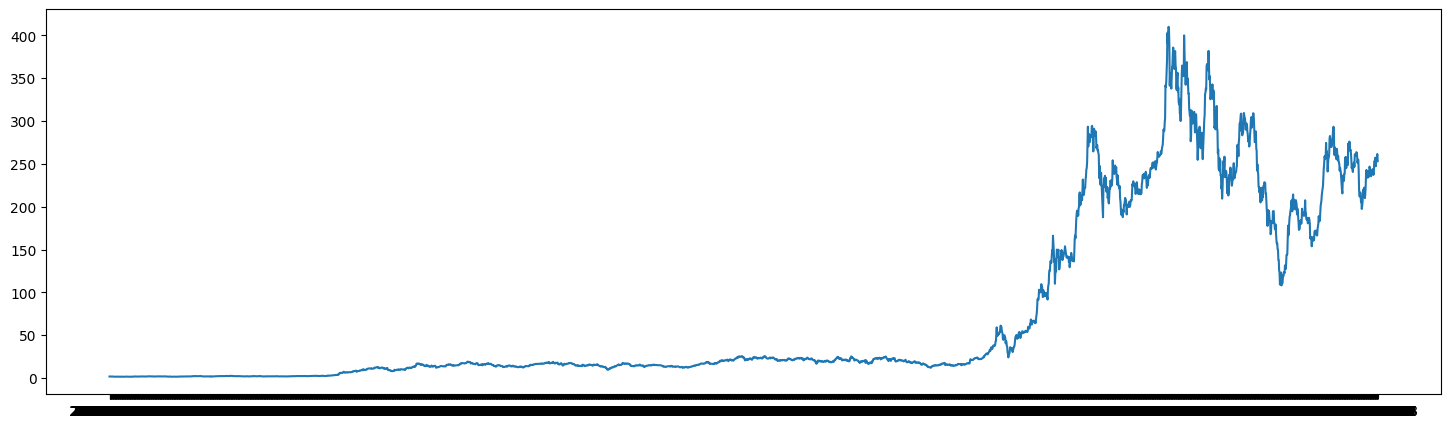

In [25]:
plt.figure(figsize=(18,5))
plt.plot(dataset['date'], dataset['close'])

In [26]:
# scalling the dataset 

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Selecting the columns to scale
columns_to_scale = ['open', 'high', 'low', 'close', 'volume', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'vix', 'turbulence']

# Applying MinMaxScaler
scaler = MinMaxScaler()
dataset[columns_to_scale] = scaler.fit_transform(dataset[columns_to_scale])
dataset.head()


,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2010-12-31,0.000779,0.000804,0.000889,0.000783,0.019412,TSLA,4,0.398984,0.000273,0.001265,0.000000,0.392737,1.000000,0.000594,0.000496,0.117063,0.0
1,2011-01-03,0.000823,0.000763,0.000790,0.000782,0.017190,TSLA,0,0.398983,0.000273,0.001265,0.000000,0.392737,1.000000,0.000593,0.000495,0.115160,0.0
2,2011-01-04,0.000793,0.000755,0.000810,0.000790,0.015615,TSLA,1,0.398985,0.000281,0.001260,0.842197,0.430598,1.000000,0.000596,0.000498,0.112033,0.0
3,2011-01-05,0.000764,0.000747,0.000838,0.000816,0.019887,TSLA,2,0.398992,0.000310,0.001241,0.961784,0.500598,1.000000,0.000604,0.000507,0.107138,0.0
4,2011-01-06,0.000821,0.000925,0.000940,0.000987,0.030010,TSLA,3,0.399039,0.000480,0.001110,0.997687,0.709187,0.382254,0.000648,0.000552,0.112305,0.0


In [27]:
# split the dataset into training and testing 

train_df = dataset[dataset['date'] < '2021-12-31']
trade_df = dataset[dataset['date'] >= '2022-01-01']

In [28]:
# defining the state space and stock dimension

stock_dimension = len(train_df.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 1, State Space: 11


In [29]:
# setting up the environment with the state space

env_kwargs = {
    "hmax": 100, # maximum number of shares to trade
    "initial_amount": 1000000, # initial amount of cash
    "buy_cost_pct": [0.001], # transaction cost percentage
    "sell_cost_pct": [0.001], # transaction cost percentage
    "state_space": state_space, # state space
    "stock_dim": stock_dimension, # number of stocks
    "tech_indicator_list": INDICATORS, # list of technical indicators
    "action_space": stock_dimension, # number of actions
    "reward_scaling": 1e-4, # scaling factor for rewards
    "print_verbosity":10, # verbosity level
    "num_stock_shares": [0] * stock_dimension,
}

e_train_gym = StockTradingEnv(df = train_df, **env_kwargs)

print(e_train_gym.action_space)

Box(-1.0, 1.0, (1,), float32)


In [30]:
# training the agent with the training dataset
from stable_baselines3.common.logger import configure
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))
agent = DRLAgent(env = env_train)
if_using_a2c = True
model_a2c = agent.get_model("a2c")

if if_using_a2c:
  # set up logger
  tmp_path = RESULTS_DIR + '/a2c'
  new_logger_a2c = configure(tmp_path, ["stdout", "csv", "tensorboard"])
  # Set new logger
  model_a2c.set_logger(new_logger_a2c)

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>
{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device
Logging to results/a2c


In [31]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000
                             ) 
                             

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 270           |
|    iterations         | 100           |
|    time_elapsed       | 1             |
|    total_timesteps    | 500           |
| train/                |               |
|    entropy_loss       | -1.55         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.0007        |
|    n_updates          | 99            |
|    policy_loss        | -0.000171     |
|    reward             | 2.7120532e-05 |
|    std                | 1.14          |
|    value_loss         | 5.24e-08      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 386          |
|    iterations         | 200          |
|    time_elapsed       | 2            |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -1.63        |


d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


----------------------------------------
| time/                 |              |
|    fps                | 538          |
|    iterations         | 600          |
|    time_elapsed       | 5            |
|    total_timesteps    | 3000         |
| train/                |              |
|    entropy_loss       | -1.81        |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 599          |
|    policy_loss        | -0.000979    |
|    reward             | 4.316903e-05 |
|    std                | 1.48         |
|    value_loss         | 5.25e-07     |
----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 561            |
|    iterations         | 700            |
|    time_elapsed       | 6              |
|    total_timesteps    | 3500           |
| train/                |                |
|    entropy_loss       | -1.84          |


d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 613           |
|    iterations         | 1700          |
|    time_elapsed       | 13            |
|    total_timesteps    | 8500          |
| train/                |               |
|    entropy_loss       | -2.25         |
|    explained_variance | 0             |
|    learning_rate      | 0.0007        |
|    n_updates          | 1699          |
|    policy_loss        | -0.00357      |
|    reward             | 0.00017018635 |
|    std                | 2.3           |
|    value_loss         | 2.15e-06      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 614           |
|    iterations         | 1800          |
|    time_elapsed       | 14            |
|    total_timesteps    | 9000          |
| train/                |               |
|    entropy_loss       | -2.27   

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 639           |
|    iterations         | 2900          |
|    time_elapsed       | 22            |
|    total_timesteps    | 14500         |
| train/                |               |
|    entropy_loss       | -2.62         |
|    explained_variance | 1.19e-07      |
|    learning_rate      | 0.0007        |
|    n_updates          | 2899          |
|    policy_loss        | 0.000886      |
|    reward             | -8.151758e-05 |
|    std                | 3.33          |
|    value_loss         | 2.11e-07      |
-----------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 642          |
|    iterations         | 3000         |
|    time_elapsed       | 23           |
|    total_timesteps    | 15000        |
| train/                |              |
|    entropy_loss       | -2.66        |


d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 645           |
|    iterations         | 3400          |
|    time_elapsed       | 26            |
|    total_timesteps    | 17000         |
| train/                |               |
|    entropy_loss       | -2.83         |
|    explained_variance | -1.19e-07     |
|    learning_rate      | 0.0007        |
|    n_updates          | 3399          |
|    policy_loss        | -0.000544     |
|    reward             | 0.00013794741 |
|    std                | 4.09          |
|    value_loss         | 6.37e-08      |
-----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 646            |
|    iterations         | 3500           |
|    time_elapsed       | 27             |
|    total_timesteps    | 17500          |
| train/                |                |
|    entropy_loss       | -

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


------------------------------------------
| time/                 |                |
|    fps                | 661            |
|    iterations         | 4500           |
|    time_elapsed       | 34             |
|    total_timesteps    | 22500          |
| train/                |                |
|    entropy_loss       | -3.33          |
|    explained_variance | 0              |
|    learning_rate      | 0.0007         |
|    n_updates          | 4499           |
|    policy_loss        | -0.000968      |
|    reward             | -5.9002414e-05 |
|    std                | 6.74           |
|    value_loss         | 1.15e-07       |
------------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 662           |
|    iterations         | 4600          |
|    time_elapsed       | 34            |
|    total_timesteps    | 23000         |
| train/                |               |
|    entropy_loss 

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 666           |
|    iterations         | 5100          |
|    time_elapsed       | 38            |
|    total_timesteps    | 25500         |
| train/                |               |
|    entropy_loss       | -3.58         |
|    explained_variance | 1.19e-07      |
|    learning_rate      | 0.0007        |
|    n_updates          | 5099          |
|    policy_loss        | 0.00157       |
|    reward             | 0.00014387598 |
|    std                | 8.68          |
|    value_loss         | 2.04e-07      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 667           |
|    iterations         | 5200          |
|    time_elapsed       | 38            |
|    total_timesteps    | 26000         |
| train/                |               |
|    entropy_loss       | -3.62   

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


----------------------------------------
| time/                 |              |
|    fps                | 673          |
|    iterations         | 5600         |
|    time_elapsed       | 41           |
|    total_timesteps    | 28000        |
| train/                |              |
|    entropy_loss       | -3.77        |
|    explained_variance | 0            |
|    learning_rate      | 0.0007       |
|    n_updates          | 5599         |
|    policy_loss        | -0.0033      |
|    reward             | 3.904375e-05 |
|    std                | 10.5         |
|    value_loss         | 7.88e-07     |
----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 674            |
|    iterations         | 5700           |
|    time_elapsed       | 42             |
|    total_timesteps    | 28500          |
| train/                |                |
|    entropy_loss       | -3.8           |


d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


----------------------------------------
| time/                 |              |
|    fps                | 677          |
|    iterations         | 6200         |
|    time_elapsed       | 45           |
|    total_timesteps    | 31000        |
| train/                |              |
|    entropy_loss       | -4.1         |
|    explained_variance | -1.19e-07    |
|    learning_rate      | 0.0007       |
|    n_updates          | 6199         |
|    policy_loss        | -2.41e-06    |
|    reward             | 1.072838e-06 |
|    std                | 14.6         |
|    value_loss         | 1.07e-12     |
----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 677           |
|    iterations         | 6300          |
|    time_elapsed       | 46            |
|    total_timesteps    | 31500         |
| train/                |               |
|    entropy_loss       | -4.17         |
|    exp

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 705           |
|    iterations         | 9000          |
|    time_elapsed       | 63            |
|    total_timesteps    | 45000         |
| train/                |               |
|    entropy_loss       | -5.97         |
|    explained_variance | 0             |
|    learning_rate      | 0.0007        |
|    n_updates          | 8999          |
|    policy_loss        | 0.000118      |
|    reward             | -8.192479e-05 |
|    std                | 94.4          |
|    value_loss         | 1.16e-09      |
-----------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 705           |
|    iterations         | 9100          |
|    time_elapsed       | 64            |
|    total_timesteps    | 45500         |
| train/                |               |
|    entropy_loss       | -6.03   

d:\RL-Project\Py310-venv\lib\site-packages\finrl\meta\env_stock_trading\env_stocktrading.py:179: RuntimeWarning: divide by zero encountered in scalar floor_divide
  available_amount = self.state[0] // (


-----------------------------------------
| time/                 |               |
|    fps                | 704           |
|    iterations         | 9500          |
|    time_elapsed       | 67            |
|    total_timesteps    | 47500         |
| train/                |               |
|    entropy_loss       | -6.31         |
|    explained_variance | 0             |
|    learning_rate      | 0.0007        |
|    n_updates          | 9499          |
|    policy_loss        | 0.00017       |
|    reward             | 1.7484674e-05 |
|    std                | 133           |
|    value_loss         | 9.93e-10      |
-----------------------------------------
------------------------------------------
| time/                 |                |
|    fps                | 704            |
|    iterations         | 9600           |
|    time_elapsed       | 68             |
|    total_timesteps    | 48000          |
| train/                |                |
|    entropy_loss       | -

In [32]:
# save the trained model
trained_a2c.save(TRAINED_MODEL_DIR + "/agent_a2c")


d:\RL-Project\Py310-venv\lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'trained_models' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")
